In [1]:
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from collections import defaultdict
import os


# ParetoSet

In [2]:
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt

class Solution(ABC):
    """
    Abstract base class for solutions in multi-objective optimization.

    Parameters:
    - solution_values (list): List of objective values.

    Returns:
    - None
    """
    @abstractmethod
    def __init__(self, solution_values):
        pass

    @abstractmethod
    def dominates(self, other):
        """
        Check if this solution dominates another.

        Parameters:
        - other (BiObjSolution): Another bi-objective solution.

        Returns:
        - bool: True if this solution dominates the other, False otherwise.
        """
        pass

class BiObjSolution(Solution):
    """
    Class representing a bi-objective solution.
    """
    def __init__(self, solution_values):
        """
        Initialize a bi-objective solution with the given values.

        Parameters:
        - solution_values (list): List of objective values.
        """
        self.solution_values = tuple(solution_values)
        self.g1 = solution_values[0]
        self.g2 = solution_values[1]

    def dominates(self, other: 'BiObjSolution'):
        """
        Check if this solution dominates another.

        Parameters:
        - other (BiObjSolution): Another bi-objective solution.

        Returns:
        - bool: True if this solution dominates the other, False otherwise.
        """
        return (self.g1 < other.g1 and self.g2 <= other.g2) or (self.g1 <= other.g1 and self.g2 < other.g2)
    
    def is_dominated_by(self, other: 'BiObjSolution'):
        return not self.dominates(other)

    def __str__(self):
        return f"({self.g1}, {self.g2})"

    def __hash__(self) -> int:
        return hash((self.g1, self.g2))

    def __repr__(self) -> str:
        return f"BiObjSolution([{self.g1}, {self.g2}])"

    def __eq__(self, other: 'BiObjSolution') -> bool:
        return isinstance(other, BiObjSolution) and self.g1 == other.g1 and self.g2 == other.g2


class ParetoSet:
    """
    Class representing a Pareto set in multi-objective optimization.
    """
    def __init__(self, SolutionClass=BiObjSolution):
        """
        Initialize a Pareto set.

        Parameters:
        - SolutionClass (class): Class representing the type of solutions in the Pareto set.
        """
        self.solutions = set()
        self.SolutionClass = SolutionClass

        #Для визуализации
        self.max_y = 0
        self.max_x = 0
        self.all_solusions_ever = set()


    def add_solution(self, solution_values):
        """
        Add a solution to the Pareto set.

        Parameters:
        - solution_values (list): List of objective values for the new solution.
        """
        solution = self.SolutionClass(solution_values)
        non_dominated = self._is_non_dominated(solution)

        #Для визуализации
        self.all_solusions_ever.add(solution)
        self.max_x= max(self.max_x, solution.solution_values[0])
        self.max_y = max(self.max_y, solution.solution_values[1])

        if non_dominated:
            
            self.solutions = {s for s in self.solutions if not solution.dominates(s)}
            self.solutions.add(solution)

    def remove_solution(self, solution_values):
        """
        Remove a solution from the Pareto set.

        Parameters:
        - solution (BiObjSolution): The solution to be removed.
        """
        solution = self.SolutionClass(solution_values)
        self.solutions.remove(solution)

    def _is_non_dominated(self, solution):
        """
        Check if a solution is non-dominated by the current solutions in the set.

        Parameters:
        - solution (BiObjSolution): The solution to check.

        Returns:
        - bool: True if the solution is non-dominated, False otherwise.
        """
        return not any(s.dominates(solution) for s in self.solutions)

    def is_non_dominated(self, solution_values):
        """
        Check if a solution with given objective values is non-dominated by the current solutions in the set.

        Parameters:
        - solution_values (list): List of objective values for the solution.

        Returns:
        - bool: True if the solution is non-dominated, False otherwise.
        """
        solution = self.SolutionClass(solution_values)
        return not any(s.dominates(solution) for s in self.solutions)

    def get_solutions(self,values=True):
        """
        Get the current solutions in the Pareto set.

        Parameters:
        - values (bool): If True, return a set of solution values. If False, return a set of solution objects.
        Default is True.

        Returns:
        - set: Set of solutions in the Pareto set. If values is True, it contains tuples of solution values.
        If values is False, it contains solution objects.
        """
        if values:
            return {s.solution_values for s in self.solutions}
        return self.solutions

    def solutions_dominated_by(self, solution_values):
        """
        Get solutions in the Pareto set that are dominated by a given solution.

        Parameters:
        - solution_values (list): List of objective values for the dominating solution.

        Returns:
        - list: List of solutions dominated by the given solution.
        """
        solution = self.SolutionClass(solution_values)
        return [s for s in self.solutions if solution.dominates(s)]

    def _solutions_dominated_by(self, solution):
        """
        Get solutions in the Pareto set that are dominated by a given solution.

        Parameters:
        - solution (BiObjSolution): The dominating solution.

        Returns:
        - list: List of solutions dominated by the given solution.
        """
        return [s for s in self.solutions if solution.dominates(s)]

    def remove_worse(self, better_solution_values):
        """
        Remove solutions from the Pareto set that are dominated by a better solution.

        Parameters:
        - better_solution_values (list): List of objective values for the better solution.
        """
        better_solution = self.SolutionClass(better_solution_values)
        self.solutions.difference_update(self._solutions_dominated_by(better_solution))

    def visualize(self, color='blue', marker='o'):
        """
        Visualize the current Pareto set.

        Parameters:
        - color (str): Color of the scatter plot (default is 'blue').
        - marker (str): Marker style for the scatter plot (default is 'o').
        """
        if not self.solutions:
            print("Empty Pareto set. Nothing to visualize.")
            return
        x_values, y_values = zip(*[(sol.g1, sol.g2) for sol in self.solutions])
        plt.scatter(x_values, y_values, label='Pareto Set', color=color, marker=marker, s=100, edgecolors='black')
        plt.xlabel('Objective 1')
        plt.ylabel('Objective 2')
        plt.title('Pareto Set Visualization')
        plt.grid(True, linestyle='--', which='both', alpha=0.7)
        plt.show()

    def __str__(self) -> str:
        return f"({', '.join(str(sol) for sol in self.solutions)})"

    def __contains__(self, solution_values):
        """
        Check if a solution with given objective values is in the Pareto set.

        Parameters:
        - solution_values (list): List of objective values for the solution.

        Returns:
        - bool: True if the solution is in the Pareto set, False otherwise.
        """
        solution = self.SolutionClass(solution_values)
        return solution in self.solutions


# Graph

In [3]:
class Graph:
    """
    Represents an undirected graph with weighted edges.

    Attributes:
        adjacency_list: A defaultdict containing vertices as keys and dictionaries of neighbors and their costs as values.
        vertices: A set containing all vertices in the graph.
    """

    def __init__(self):
        """
        Initializes an empty graph.
        """
        self.adjacency_list = defaultdict(dict)
        self.vertices = set()

    def add_edge(self, vertex1, vertex2, cost1, cost2):
        """
        Adds an edge to the graph.

        Parameters:
        - vertex1: The first vertex of the edge.
        - vertex2: The second vertex of the edge.
        - cost1: The cost associated with the edge from vertex1 to vertex2.
        - cost2: The cost associated with the edge from vertex2 to vertex1.
        """
        self.adjacency_list[vertex1][vertex2] = (cost1, cost2)
        self.vertices.update([vertex1, vertex2])

    def read_from_file(self, file_path):
        """
        Reads graph data from a file and updates the graph.

        Parameters:
        - file_path: The path to the file containing graph data in the format: vertex1 vertex2 cost1 cost2
        """
        self.adjacency_list = defaultdict(dict)
        self.vertices = set()
        try:
            with open(file_path, 'r') as file:
                for line in file:
                    vertex1, vertex2, cost1, cost2 = map(int, line.split())
                    self.add_edge(vertex1, vertex2, cost1, cost2)
        except FileNotFoundError:
            print(f"File {file_path} not found.")

    def print_graph(self):
        """
        Prints the graph in the format: V1 -> V2 : C1, C2
        """
        print("  V1 -> V2  :  C1, C2")
        for vertex, edges in self.adjacency_list.items():
            for neighbor, costs in edges.items():
                print(f"{vertex:>4} -> {neighbor:<4}: {costs[0]:>3}, {costs[1]}")

    def get_neighbors(self, state):
        """
        Gets the neighbors of a given vertex.

        Parameters:
        - state: The vertex for which neighbors are requested.

        Returns:
        - list: A list of tuples containing neighbors and their costs.
        """
        if state in self.adjacency_list:
            return list(self.adjacency_list[state].items())
        return []

    @property
    def graph(self):
        """
        Gets the adjacency list representation of the graph.

        Returns:
        - dict: The adjacency list of the graph.
        """
        return self.adjacency_list

# Search Tree PQD

In [4]:
from heapq import heapify, heappop, heappush
from typing import Optional


class Node:
    """
    Represents a node in the search tree.

    Attributes:
        state: The state represented by the node.
        g1, g2: Values of the cost function g from two sources.
        g_values: Tuple containing the g values.
        h1, h2: Values of the heuristic function h from two sources.
        h_values: Tuple containing the h values.
        f: Tuple containing the sum of g and h values from both sources.
        parent: The parent node in the search tree.
    """

    def __init__(self, state, g_values, h_values=(0,0), parent=None):
        """
        Initializes a node in the search tree.

        Parameters:
        - state: The state represented by the node.
        - g_values: Tuple containing two values of the cost function g.
        - h_values: Tuple containing two values of the heuristic function h.
        - parent: The parent node in the search tree.
        """
        self.state = state
        self.g1, self.g2 = g_values
        self.g_values = g_values
        self.h1, self.h2 = h_values
        self.h_values = h_values
        self.f = (self.g1 + self.h1, self.g2 + self.h2)
        self.parent = parent
        
    def __eq__(self, other: 'Node'):
        """
        Checks if two nodes are equal.

        Parameters:
        - other (Node): The other node to compare.

        Returns:
        - bool: True if the nodes are equal, False otherwise.
        """
        return (
            self.state == other.state and
            self.g_values == other.g_values and
            self.h_values == other.h_values and
            self.parent == other.parent
        )

    def __hash__(self) -> int:
        """
        Returns the hash value of the node.

        Returns:
        - int: The hash value.
        """
        return hash((self.state, self.g_values, self.h_values, self.parent))

    def __lt__(self, other: 'Node'):
        """
        Compares two nodes based on their total cost values.

        Parameters:
        - other (Node): The other node to compare.

        Returns:
        - bool: True if the current node has a lower total cost than the other, False otherwise.
        """
        return self.f < other.f
    
    def is_dominates(self, other: 'Node'):
        """
        Checks if the current node dominates another node.

        Parameters:
        - other (Node): The other node to compare.

        Returns:
        - bool: True if the current node dominates the other, False otherwise.
        """
        return self.f <= other.f
    
    def __str__(self) -> str:
        """
        Returns a string representation of the node.

        Returns:
        - str: A string representation of the node.
        """
        return f"{self.state, self.f}"


class SearchTreePQD:
    """
    Represents a priority queue-based search tree.

    Attributes:
        _open: A list representing the open set in the search tree.
        _closed: A dictionary representing the closed set in the search tree.
    """

    def __init__(self):
        """
        Initializes an empty search tree.
        """
        self._open = []
        self._closed = {}

    def __len__(self) -> int:
        """
        Returns the total number of nodes in the search tree.

        Returns:
        - int: The total number of nodes.
        """
        return len(self._open) + len(self._closed)

    def open_is_empty(self) -> bool:
        """
        Checks if the open set is empty.

        Returns:
        - bool: True if the open set is empty, False otherwise.
        """
        return not self._open

    def add_to_open(self, item: Node):
        """
        Adds a node to the open set.

        Parameters:
        - item (Node): The node to be added.
        """
        heappush(self._open, item)

    def get_best_node_from_open(self) -> Optional[Node]:
        """
        Gets and removes the best node from the open set.

        Returns:
        - Node or None: The best node or None if the open set is empty.
        """
        while self._open:
            best_node = heappop(self._open)
            if not self.was_expanded(best_node):
                return best_node
        return None
    
    def remove_worse_nodes(self, better_node: 'Node'):
        """
        Removes nodes from the search tree that are dominated by the specified node.

        Parameters:
        - better_node (Node): The node dominating others.
        """
        self._open = [node for node in self._open if not better_node.is_dominates(node)] 
        heapify(self._open)

    def remove_worse_opened(self, state, better_f):
        """
        Clears the open set from nodes with states dominated by the specified state and f value.

        Parameters:
        - state: The state to compare.
        - better_f: The f value dominating other f values.
        """
        better_node = Node(state, better_f)
        new_open = [node for node in self._open if node.state != better_node.state or not better_node.is_dominates(node)]
        self._open = new_open
        heapify(self._open)
        
    def add_to_closed(self, item: Node):
        """
        Adds a node to the closed set.

        Parameters:
        - item (Node): The node to be added.
        """
        self._closed[item] = item

    def was_expanded(self, item: Node) -> bool:
        """
        Checks if a node has been expanded.

        Parameters:
        - item (Node): The node to check.

        Returns:
        - bool: True if the node has been expanded, False otherwise.
        """
        return item in self._closed

    @property
    def opened(self):
        """
        Gets the open set of the search tree.

        Returns:
        - list: The open set.
        """
        return self._open


# Bi-Objective Dijkstra

In [5]:
def construct_path(node: Node):
    """
    Construct a path from the given node to the root.

    Parameters:
        node (Node): The current node.

    Returns:
        list: A list of states representing the path.
    """
    path = [node]
    path_ids = [node.state]
    prev_node = node.parent
    while prev_node is not None:
        path.append(prev_node)
        path_ids.append(prev_node.state)
        prev_node = prev_node.parent
    return path_ids[::-1]

def BODijkstra(search_graph: Graph, start_state, search_tree=SearchTreePQD):
    """
    Bi-Objective Dijkstra algorithm to find Pareto-optimal paths.

    Parameters:
        search_graph (Graph): The graph to search.
        start_state: The starting state.
        search_tree (type): The type of search tree to use.

    Returns:
        tuple: Pareto-optimal solutions, all paths, and discarded paths.
    """
    solutions = defaultdict(ParetoSet)
    g2_min = defaultdict(lambda: float('inf'))
    start_node = Node(state=start_state, g_values=(0, 0), parent=None)
    search_tree = search_tree()
    search_tree.add_to_open(start_node)

    # For visualization
    discarded_paths = defaultdict(list)  # Vertex: all paths rejected at this vertex
    all_paths = defaultdict(list)  # Vertex: all paths that ever entered the solution and lead to it

    while not search_tree.open_is_empty():
        x = search_tree.get_best_node_from_open()  # Retrieve nodes in lexicographical order
        if x.g2 >= g2_min[x.state]:
            discarded_paths[x.state].append(construct_path(x))
            continue

        g2_min[x.state] = x.g2
        solutions[x.state].add_solution(x.g_values)
        all_paths[x.state].append(construct_path(x))

        for state, costs in search_graph.get_neighbors(x.state):
            neighbour_g = tuple(x + y for x, y in zip(x.g_values, costs))
            y = Node(state, g_values=neighbour_g, parent=x)
            if y.g2 >= g2_min[state]:
                discarded_paths[state].append(construct_path(y))
                continue
            search_tree.add_to_open(y)

    return solutions, all_paths, discarded_paths


## Task Visulaizator

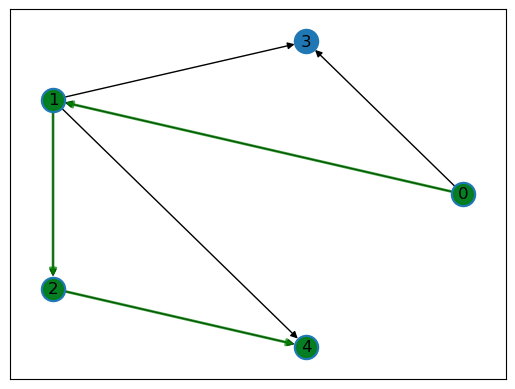

In [30]:
import matplotlib.pyplot as plt
import networkx as nx


class TaskVisualizator:
    def __init__(self, graph: dict) -> None:
        self.graph = graph
        self.graph_plot = nx.DiGraph()

    def set_new_graph(self, new_graph):
        self.graph_plot = nx.DiGraph()
        self.graph = new_graph
        self.fig, self.ax = plt.subplots()
        self.pos = nx.circular_layout(self.graph_plot)

    def draw_path(self, path_nodes: list, edge_color='green'):
        path_edges_list = [(path_nodes[i], path_nodes[i+1]) for i in range(len(path_nodes)-1)]
        nx.draw_networkx_edges(self.graph_plot, self.pos, ax=self.ax, edgelist=path_edges_list,  edge_color=edge_color, width=2, alpha=0.7)
        nx.draw_networkx_nodes(self.graph_plot, self.pos, ax=self.ax, node_color=edge_color, nodelist=path_nodes, node_size=200, alpha=0.8)

    
    def draw_graph(self):
        """
        Отрисовывает основной граф, т.е тот, который даётся в самом задании
        """
        self.edge_list = []
        for node1 in self.graph:
            for node2 in self.graph[node1]:
                self.edge_list.append((node1, node2, {"w": f"{self.graph[node1][node2][0], self.graph[node1][node2][1]}"}))
        
        self.graph_plot.add_edges_from(self.edge_list)
        # pos=nx.spring_layout(self.graph_plot, seed=1)
        self.pos = nx.circular_layout(self.graph_plot)
        
        nx.draw_networkx_nodes(self.graph_plot, self.pos, ax=self.ax)
        nx.draw_networkx_labels(self.graph_plot, self.pos, ax=self.ax)

        curved_edges = [edge for edge in self.graph_plot.edges() if reversed(edge) in self.graph_plot.edges()]
        straight_edges = list(set(self.graph_plot.edges()) - set(curved_edges))
        nx.draw_networkx_edges(self.graph_plot, self.pos, ax=self.ax, edgelist=straight_edges)
        arc_rad = 0.25
        nx.draw_networkx_edges(self.graph_plot, self.pos, ax=self.ax, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}')


task_medium = Graph()
task_medium.read_from_file("../testdata/bdijkstra/easy/easy_task.txt")
sols, all, all2 = BODijkstra(task_medium, 0, SearchTreePQD)

t = TaskVisualizator(None)
t.set_new_graph(task_medium.graph)
t.draw_graph()
t.draw_path([0, 1, 2, 4])

In [32]:
from IPython.display import display, clear_output

def visualize_path(graph, start, stop, good_path=[], bad_path=[]):
    edge_list = []
    for node1 in graph:
        for node2 in graph[node1]:
            edge_list.append((node1, node2, {"w": f"{graph[node1][node2][0], graph[node1][node2][1]}"}))

    G = nx.DiGraph()

    G.add_edges_from(edge_list)
    pos=nx.spring_layout(G,seed=1)
    pos=nx.circular_layout(G)
    fig, ax = plt.subplots()
    nx.draw_networkx_nodes(G, pos, ax=ax)
    
    nx.draw_networkx_labels(G, pos, ax=ax)

    curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
    straight_edges = list(set(G.edges()) - set(curved_edges))
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=straight_edges)
    arc_rad = 0.25
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}')

    edge_weights = nx.get_edge_attributes(G,'w')
    curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
    straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=curved_edge_labels,rotate=False,rad = arc_rad)
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=straight_edge_labels,rotate=False)


    if good_path:
        edge_list = [(good_path[i], good_path[i+1]) for i in range(len(good_path)-1)]
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edge_list, edge_color='green')
        nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=[start, stop], node_color="green")
    elif bad_path:
        edge_list = [(bad_path[i], bad_path[i+1]) for i in range(len(bad_path)-1)]
        nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=[start, stop], node_color="red")
        nx.draw_networkx_edges(G, pos, ax=ax, edgelist=edge_list, edge_color='red')
    plt.show()

class TestVisualizator:
    def __init__(self, testdata_folder: str) -> None:
        self.testdata_folder = testdata_folder
        self.tests_files_list = [f for f in os.listdir(testdata_folder) if os.path.isfile(os.path.join(testdata_folder, f))]
        self.selected_testfile = None
        self.task = Graph()
        self.nodes = []
        self.max_slider_len = 1
        self.task_visualizator = TaskVisualizator(None)

        self.sols = None

        self.file_dropdown = widgets.Dropdown(
            options=sorted(self.tests_files_list),
            value=None,
            description='Select File:'
        )   

        self.start_node_dropdown = widgets.Dropdown(
            options=self.nodes,
            value=None,
            description='Start Node:',
            disabled=False,
        )

        self.end_node_dropdown = widgets.Dropdown(
            options=self.nodes,
            value=None,
            description='End Node:',
            disabled=False,
        )

        self.path_choice_radio = widgets.RadioButtons(
            options=['Good Path', 'Bad Path'],
            value='Good Path',
            description='Path Choice:',
            disabled=False,
        )

        self.path_slider = widgets.IntSlider(
            value=None,
            min=None,
            max=self.max_slider_len,
            step=1,
            description='Path Number:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='d'
        )

        self.output = widgets.Output()  # Создаем виджет Output для вывода результата
        self.file_path = None

        self.file_dropdown.observe(self.handle_file_selection, names='value')

        self.start_node_dropdown.observe(self.update_plots, names='value')
        self.end_node_dropdown.observe(self.update_plots, names='value')
        self.path_choice_radio.observe(self.update_plots, names='value')

        self.path_slider.observe(self.update_plots, names='value')

        self.left_column = widgets.VBox([self.start_node_dropdown, self.end_node_dropdown], layout=widgets.Layout(margin='0 10px 0 0'))
        self.right_column = widgets.VBox([self.path_choice_radio], layout=widgets.Layout(margin='0 0 0 10px',))

        # Выводим виджеты
        self.file_dropdown.value = sorted(self.tests_files_list)[0]  # Устанавливаем значение после отображения
        display(self.file_dropdown, self.output, widgets.HBox([self.left_column, self.right_column, self.path_slider], layout=widgets.Layout(margin='5px 0 0 0')))

    def handle_file_selection(self, change):
        selected_file = self.file_dropdown.value
        if selected_file is not None:
            file_path = os.path.join(self.testdata_folder, selected_file)
            with self.output:
                self.output.clear_output(wait=True)
                self.task.read_from_file(file_path)
                self.task_visualizator.set_new_graph(self.task.graph)
                self.task_visualizator.draw_graph()
        self.update_nodes_dropdown()

    def update_nodes_dropdown(self):
        self.nodes = sorted(list(self.task.vertices))
        self.start_node_dropdown.options =  self.nodes
        self.start_node_dropdown.value = self.nodes[0]

        self.end_node_dropdown.options =  self.nodes
        self.end_node_dropdown.value = self.nodes[1]

    def update_slider_max(self):
        self.path_slider.max = self.max_slider_len
        self.path_slider.value = 1


    def update_plots(self, change):
        start_node = self.start_node_dropdown.value
        end_node = self.end_node_dropdown.value
        path_choice = self.path_choice_radio.value

        
        
        path_number = self.path_slider.value - 1

        with self.output:
            self.output.clear_output(wait=True)

            if path_choice == 'Good Path':
                self.max_slider_len = len(good_paths)
                paths = good_paths.get(end_node, [])
                print(f"Good path for NODE {end_node}: {good_paths}")
                if paths:
                    path = paths[path_number]
                    visualize_path(self.task.graph, start_node, end_node, path)
            else:
                self.max_slider_len = len(good_paths)
                paths = bad_paths.get(end_node, [])
                if paths:
                    path = paths[path_number]
                    visualize_path(self.task.graph, start_node, end_node, path)
        
        self.update_slider_max()




TestVisualizator("../testdata")

Dropdown(description='Select File:', options=('test_easy_1.txt', 'test_easy_2.txt', 'test_easy_3.txt', 'test_e…

Output()

# Test Easy

![](../testdata/bdijkstra/easy/easy.png)

## Test Medium

![](../testdata/bdijkstra/medium/medium.png)